# Classification. Linear models and KNN

In [225]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [593]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [227]:
from sklearn.exceptions import NotFittedError

In [347]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        z = np.dot(X, weights)
        return 1 / (1 + np.exp(-z))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        n_samples = x.shape[0]
        margin = x.dot(weights) * y
        regul = (1 / (2 * self.C)) * (np.linalg.norm(weights, ord=1) ** 2)
        loss = 1 / n_samples * np.sum(np.log(1 + np.exp(-margin))) + regul
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept (column of ones added)
        num_features = X_ext.shape[1]
        n_samples = X_ext.shape[0]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
#         matrix form - works with zero weights only   
#         delta = 1/X_ext.shape[0]*((y@X_ext)*(1/(1+np.exp(-(X_ext@self.weights_)@y)))) - (1 / self.C) * self.weights_ 

        self.loss_history = []
        for i in range(self.max_iter):
            delta_list = []
            weights = self.weights_
            for j in range(n_samples):
                delta = (y[j]*X_ext[j])*(1 - 1/(1+np.exp(-(weights@X_ext[j])*y[j])))
                delta_list.append(delta)
            delta = -(np.sum(delta_list, axis=0) / n_samples)
            self.weights_ = weights - self.eta * (delta - (1 / self.C) * weights)
            
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            
            if i > self.max_iter or np.linalg.norm(self.weights_ - weights) < self.tol:
                break
                
        return self
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y_pred = self.predict_proba(X)
        for i in range(len(y_pred)):
            if y_pred[i] >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        y_pred
        return y_pred

In [291]:
from sklearn import datasets
from sklearn import metrics

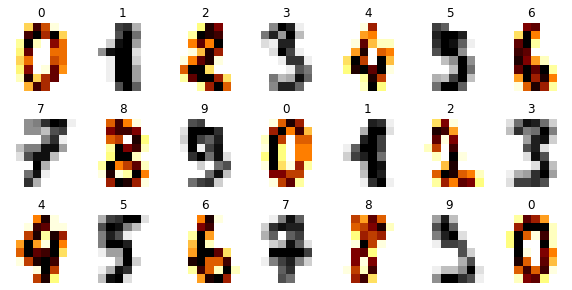

In [621]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [622]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [623]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [624]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [625]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))
print('success')

success


In [ ]:
lr_clf.fit(X_train, y_train)

In [627]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)
print('success')

success


In [628]:
model = CustomLogisticRegression()

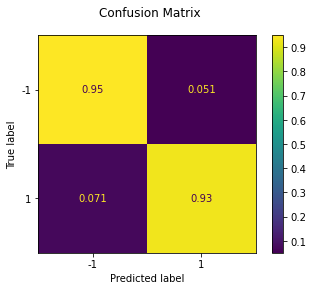

In [629]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [302]:
train_acc, test_acc

(0.9157967988865693, 0.9388888888888889)

In [614]:
assert min(train_acc, test_acc) > 0.9
print('success')

success


**(0.5 points)** Visualize the loss history.

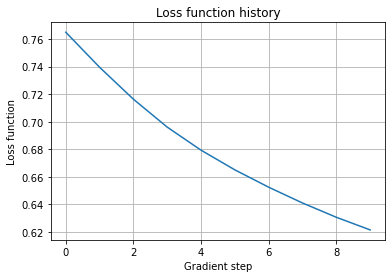

In [630]:
model = CustomLogisticRegression(max_iter=10)
loss_function_values = np.array(model.fit(X_train, y_train).loss_history)
x = np.arange(0, loss_function_values.shape[0])
plt.title("Loss function history")
plt.xlabel("Gradient step")
plt.ylabel("Loss function")
plt.plot(x, loss_function_values)
plt.grid()
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

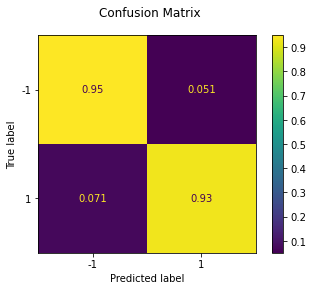

(0.9157967988865693, 0.9388888888888889)

In [287]:
model1 = CustomLogisticRegression()  #eta=0.001
train_acc, test_acc = fit_evaluate(model1, X_train, y_train, X_test, y_test)
train_acc, test_acc

C:\Users\SAVELY~1\AppData\Local\Temp/ipykernel_6888/4230344573.py:66: RuntimeWarning: overflow encountered in exp
  delta = (y[j]*X_ext[j])*(1 - 1/(1+np.exp(-(weights@X_ext[j])*y[j])))
C:\Users\SAVELY~1\AppData\Local\Temp/ipykernel_6888/4230344573.py:32: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


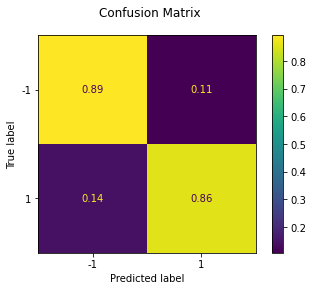

C:\Users\SAVELY~1\AppData\Local\Temp/ipykernel_6888/4230344573.py:32: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\SAVELY~1\AppData\Local\Temp/ipykernel_6888/4230344573.py:32: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


(0.8622129436325678, 0.875)

In [320]:
model2 = CustomLogisticRegression(eta=0.5)
train_acc, test_acc = fit_evaluate(model2, X_train, y_train, X_test, y_test)
train_acc, test_acc

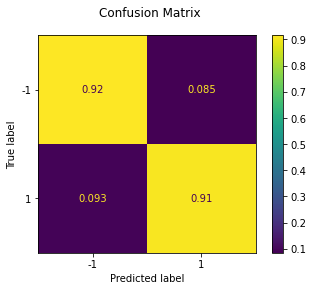

(0.8872651356993737, 0.9111111111111111)

In [321]:
model3 = CustomLogisticRegression(eta=0.0001)
train_acc, test_acc = fit_evaluate(model3, X_train, y_train, X_test, y_test)
train_acc, test_acc

**Learning rate** is a hyper-parameter that defines the adjustment in the weights of the model with respect to the loss gradient descent. It determines how fast or slow the algorithm will move towards the optimal weights.    
If the learning rate is **very large** the optimal solution will be skipped. If it is **too small** too many iterations to converge to the best values will be needed.    
Both smaller and larger learning rates lead to the accuracy decrease. 

**(0.5 points)** Try different regularization parameter values and compare the model quality.

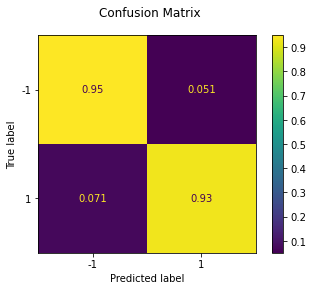

(0.9157967988865693, 0.9388888888888889)

In [323]:
model1 = CustomLogisticRegression()
train_acc, test_acc = fit_evaluate(model1, X_train, y_train, X_test, y_test)
train_acc, test_acc

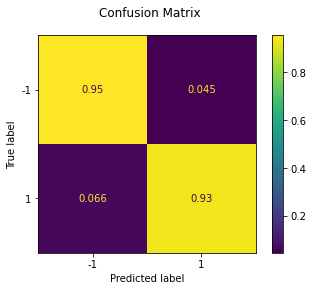

(0.9137091162143354, 0.9444444444444444)

In [327]:
model2 = CustomLogisticRegression(C=-2.0)
train_acc, test_acc = fit_evaluate(model2, X_train, y_train, X_test, y_test)
train_acc, test_acc

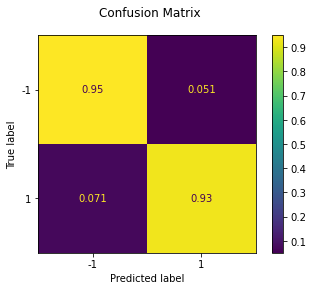

(0.9144050104384134, 0.9388888888888889)

In [325]:
model3 = CustomLogisticRegression(C=5.0)
train_acc, test_acc = fit_evaluate(model3, X_train, y_train, X_test, y_test)
train_acc, test_acc

Regularization doesn't improve the accuracy on training data, but it can be used to improve the generalization performance (performance on new, unseen data) and avoid overfitting. 

**(0.5 points)** Compare zero initialization and random initialization. 

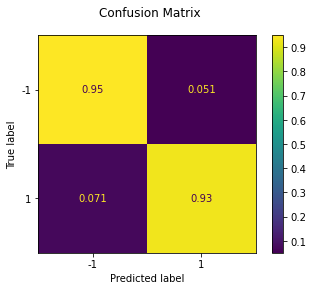

(0.9157967988865693, 0.9388888888888889)

In [349]:
model1 = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model1, X_train, y_train, X_test, y_test)
train_acc, test_acc

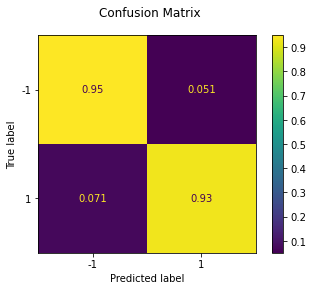

(0.9157967988865693, 0.9388888888888889)

In [319]:
model2 = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(model2, X_train, y_train, X_test, y_test)
train_acc, test_acc

Accuracy in both cases didn't change, so there's no difference how to initialize weights at the start - gradient descent algorithm would fit the weights (but it may take different amount of iterations).

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [609]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = euclidean_distances(X, Y)
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samples,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """

        df = pd.DataFrame({'y':y, 'weights':weights}).groupby('y')['weights'].sum().reset_index()
        p = []
        for cl in self.classes_:
            weight = df.loc[df['y'] == cl, 'weights'].iloc[0]
            p.append(weight)
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P - self.eps)
               
            #class_weights_sum = self.get_class_weights(self.y, weights_of_points)
            #elif self.weights == 'uniform':
            pass   
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [610]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [611]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))
print('success')

success


In [612]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))
print('success')

success


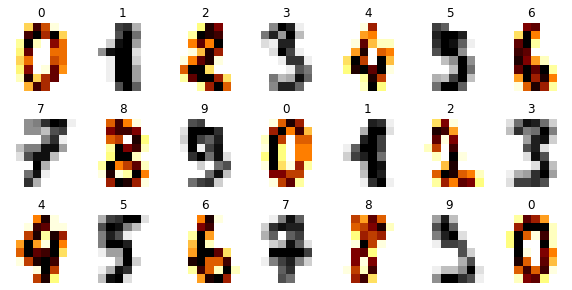

In [613]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))
print('success')

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98
print('success')

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

**Manhattan Distance** – distance between two points is the sum of the absolute differences of their Cartesian coordinates.

**Cosine Distance** – distance metric is used mainly to calculate similarity between two vectors. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in the same direction.   

**Jaccard Distance** - this approach looks at the two data sets and finds the incident where both values are equal to 1.  So the resulting value reflects how many 1 to 1 matches occur in comparison to the total number of data points.    

**Hamming Distance** - is a metric for comparing two binary data strings (could be useful when you one-hot encode the data and need to find distances between the two binary vectors).

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [461]:
PATH = "./data/"

In [462]:
data_eda = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [463]:
data_eda.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [464]:
sex_percent = data_eda['Sex'].value_counts() / len(data_eda['Sex'])
sex_percent

male      0.56114
female    0.43886
Name: Sex, dtype: float64

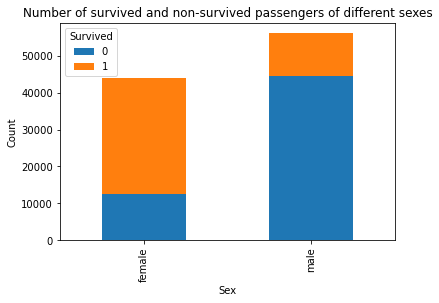

In [465]:
sex_data = data_eda.groupby(['Survived', 'Sex']).size().reset_index().pivot(columns='Survived', index='Sex', values=0)

sex_plot = sex_data.plot(kind='bar', stacked=True)
sex_plot.set(title='Number of survived and non-survived passengers of different sexes')
sex_plot.set_xlabel("Sex")
sex_plot.set_ylabel("Count");

*There are 56% of male passengers.    
There is a strong dependency between sex and survival - women have much more probability to survive*

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

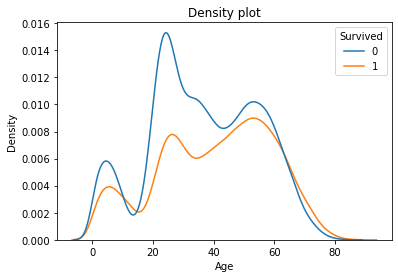

In [466]:
age_plot = sns.kdeplot(x = data_eda['Age'], hue = data_eda['Survived'], data = data_eda)
age_plot.set_title('Density plot');

In [467]:
survived = data_eda[data_eda["Survived"] == 1]
survived["Age"].describe()

count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

In [468]:
deceased = data_eda[data_eda["Survived"] == 0]
deceased["Age"].describe()

count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64

*For survived passengers mean age is 40.5 years, median is 43 years old.    
For deceased passengers mean age is 36.7 years, median is 36 years old.       
Distribution of the age of deceased passengers has peaks around 23 and 58 years. Younger and elderly people had more chances to survive.*

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

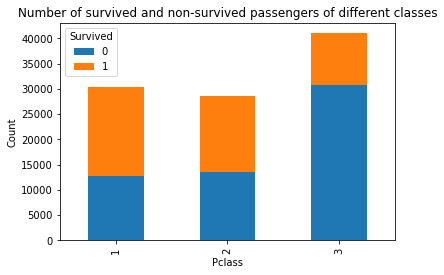

In [469]:
pclass_data = data_eda.groupby(['Survived', 'Pclass']).size().reset_index().pivot(columns='Survived', index='Pclass', values=0)

pclass_plot = pclass_data.plot(kind='bar', stacked=True)
pclass_plot.set(title='Number of survived and non-survived passengers of different classes')
pclass_plot.set_xlabel("Pclass")
pclass_plot.set_ylabel("Count");

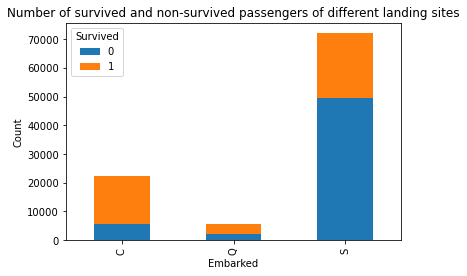

In [470]:
embarked_data = data_eda.groupby(['Survived', 'Embarked']).size().reset_index().pivot(columns='Survived', index='Embarked', values=0)

embarked_plot = embarked_data.plot(kind='bar', stacked=True)
embarked_plot.set(title='Number of survived and non-survived passengers of different landing sites')
embarked_plot.set_xlabel("Embarked")
embarked_plot.set_ylabel("Count");

*Passengers from the first class are more likely to survive.     
The most popular landing site is Southampton, Cherbourg landing site has the most survival rate.*

### Modelling

In [488]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [541]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

**(0.5 points)** Find the percentage of missing values for each feature. 

Cabin       0.67866
Ticket      0.04623
Age         0.03292
Embarked    0.00250
Fare        0.00134
Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
SibSp       0.00000
Parch       0.00000
dtype: float64

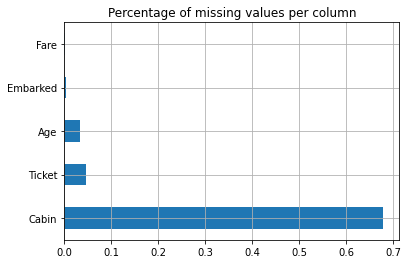

In [544]:
missing_percentage = data.isna().sum().sort_values(ascending=False) / len(data)
missing_columns = missing_percentage[missing_percentage != 0]
missing_columns.plot(kind='barh', title='Percentage of missing values per column', grid=True)
missing_percentage

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

*Embarked and Fare missing values amount is not significant, so they can be dropped. Age missing values can be filled with mean/median values, they shouldn't be dropped.* 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

### Plan    
**1) Feature engineering**    
- Extract Cabin letter and create column Deck
- Create Family size column
- Drop useless columns (SibSp, Parch, Cabin, Name, Ticket)

**2) Data preprocessing**  
- Impute data with mean for Fare
- Impute data with median for Age
- Replace missing values with 'U' (unknown) for Embarked and Deck
- Do label encoding for categorical features
- Scale data

**3) Model building**     
- Find baseline score for Logistic Regression and KNN models
- Use GridSearchCV to find best parameters
- Compare scores for both models and choose one
- Predict values and find model accuracy
- Load predictions to submit.csv and get the Kaggle score

*1.1 Extract Cabin letter and create column Deck*   
*1.2 Create Family size column*      
*1.3 Drop useless columns (SibSp, Parch, Cabin, Name, Ticket)*

In [545]:
def create_drop_columns(df):
    df['Deck'] = df['Cabin'].str.extract('([A-Za-z])')
    df['Family'] = df['Parch'] + df['SibSp']
    df.drop(['SibSp', 'Parch', 'Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

In [546]:
create_drop_columns(data)
create_drop_columns(test)

*2.1 Impute data with mean for Fare*     
*2.2 Impute data with median for Age*     
*2.2 Replace missing values with 'U' (unknown) for Embarked and Deck*            
*2.3 Do label encoding for categorical features*        
*2.4 Scale data*   

In [551]:
def deal_with_nan(df):
    df['Age'] = df['Age'].replace(np.NaN, df['Age'].median())
    df['Fare'] = df['Fare'].replace(np.NaN, df['Fare'].mean())
    df['Embarked'] = df['Embarked'].fillna('U')
    df['Deck'] = df['Deck'].fillna('U')

In [556]:
deal_with_nan(data)
deal_with_nan(test)

In [562]:
categoric_features = ['Sex', 'Embarked', 'Deck']
for feature in categoric_features:
    data[feature] = LabelEncoder().fit_transform(data[feature])
    test[feature] = LabelEncoder().fit_transform(test[feature])

In [564]:
scale = StandardScaler()
data[['Age', 'Fare']] = scale.fit_transform(data[['Age', 'Fare']])
test[['Age', 'Fare']] = scale.fit_transform(test[['Age', 'Fare']])

In [565]:
X = data.copy()
y = data['Survived']
X.drop(['Survived'], axis=1, inplace=True)

In [569]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

*3.1 Find baseline score for Logistic Regression and KNN models (with the default parameters)*    
*3.2 Use GridSearchCV to find best parameters for each model*    
*3.3 Compare scores for both models and choose one*    
*3.4 Predict values and find model accuracy*    
*3.5 Load predictions to submit.csv and get the Kaggle score*   

In [570]:
# Logistic Regression baseline score
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train, y_train, cv=5)
print(cv)

[0.7675    0.764375  0.766375  0.764875  0.7659375]


In [571]:
# KNN baseline score
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, y_train, cv=5)
print(cv)

[0.7524375 0.7500625 0.7495625 0.752375  0.7518125]


In [572]:
# Function to print model results
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [573]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train, y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.765825
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [574]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3, 5, 7, 9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1, 2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train, y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.7626000000000001
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [575]:
def fit_evaluate(clf, X_train, y_train, X_valid, y_valid):
    clf.fit(X_train, y_train)    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_valid), y_true=y_valid)

*Training models with the selected best parameters and evaluating their accuracy:*

In [576]:
final_model_lr = LogisticRegression(C=1.623776739188721, max_iter=2000, penalty='l1', solver='liblinear')
fit_evaluate(final_model_lr, X_train, y_train, X_valid, y_valid)

(0.765975, 0.76715)

In [578]:
final_model_knn = KNeighborsClassifier(algorithm='auto', n_neighbors=9, p=1, weights='uniform')
fit_evaluate(final_model_knn, X_train, y_train, X_valid, y_valid)

(0.801325, 0.7594)

*Logistic Regression model has better accuracy on test set, so it'll be used for predicting survivance for Kaggle competition.*

In [579]:
y_predicted = final_model_lr.predict(test)
y_predicted

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [588]:
submit_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submit_df['PassengerId'] = test.reset_index()['PassengerId']
submit_df['Survived'] = y_predicted
submit_df.to_csv(os.path.join(PATH, 'titanic', 'submit.csv'), index=False)

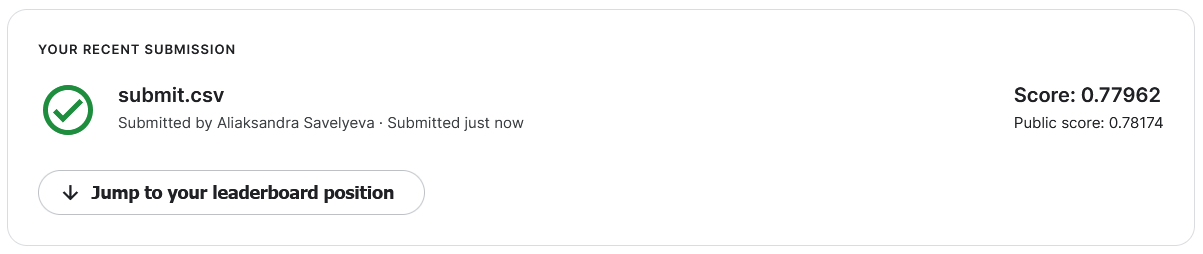